In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import sys
import warnings
import random
import pickle
import re
import os
import os.path as osp
import copy
import itertools

from tqdm.notebook import tqdm

import pandas as pd
import seaborn as sns

In [1]:
%load_ext autoreload
%autoreload 1

%aimport homstrad_util

# Prequisites

# Definitions

In [3]:
def hmstrd_seq_id(family):
    # Parse 3Di seqs
    name2ss = {k.split('.')[0]: v for k, v in homstrad_util.read_fasta(f'out/hmstrd_pdbs/{family}/ss.fasta').items()}
            
    # Parse HOMSTRAD alignment
    ref_aln = homstrad_util.parse_homstrad_ali(f'homstrad_db/{family}/{family}.ali')
    d = {}
    for name1, aa_seq_aln1 in ref_aln:
        for name2, aa_seq_aln2 in ref_aln:
            if name1 == name2:
                continue
            cnt_aa, cnt_ss = homstrad_util.cnt_identities_hmstrd(aa_seq_aln1, aa_seq_aln2, name2ss[name1], name2ss[name2])
            norm_len = min(len(name2ss[name1]), len(name2ss[name2]))
            d[(name1,name2)] = cnt_aa/norm_len, cnt_ss/norm_len
    return d

In [4]:
def hmstrd_eval(root, family, query, method):
    test_aln = homstrad_util.parse_test_ali(f'{root}/{family}/{method}.aln')
    ref_aln = homstrad_util.parse_homstrad_ali(f'homstrad_db/{family}/{family}.ali')

    name2refaln = {name: aln for name, aln in ref_aln}

    res = {'name1': [], 'name2': [], 'f1': [], 'sens': [], 'prec': []}
    for name1,name2 in test_aln:
        if query != name1:
            continue
        start1, aln1, start2, aln2 = test_aln[(name1,name2)]

        ref_pairs = homstrad_util.pairs_from_aln(0, name2refaln[name1], 0, name2refaln[name2])
        pairs = homstrad_util.pairs_from_aln(start1, aln1, start2, aln2)

        sens = len([p for p in ref_pairs if p in pairs]) / len(ref_pairs)
        prec = len([p for p in pairs if p in ref_pairs]) / len(pairs)

        res['name1'].append(name1)
        res['name2'].append(name2)
        res['sens'].append(sens)
        res['prec'].append(prec)
        res['f1'].append(2 * sens * prec / (sens + prec) if sens + prec > 0 else 0)
    return res

In [5]:
def fetch_df(fam):
    query = homstrad_util.parse_homstrad_ali(f'homstrad_db/{fam}/{fam}.ali')[0][0]
    _df_fs = pd.DataFrame(hmstrd_eval('out/hmstrd_pdbs/', fam, query, 'foldseek'))
    _df_dali = pd.DataFrame(hmstrd_eval('out/hmstrd_pdbs/', fam, query, 'dali'))
    df_fam = _df_dali.merge(_df_fs, on=('name1', 'name2'), suffixes=('_dali', '_fs'))
    
    assert len(df_fam) > 0, 'No alignments in merged df.'
    try:
        d = hmstrd_seq_id(fam)
        seqid_ss = df_fam.apply(lambda row: d[(row.name1, row.name2)][1], axis=1)
        seqid_aa = df_fam.apply(lambda row: d[(row.name1, row.name2)][0], axis=1)
    except AssertionError:
        seqid_ss = pd.NA
        seqid_aa = pd.NA
    df_fam['seqid_ss'] = seqid_ss
    df_fam['seqid_aa'] = seqid_aa
    return df_fam

# Load data

In [6]:
# Gather all intra family alignments into a single data frame
l = []
not_found = []
for fam in tqdm(os.listdir('out/hmstrd_pdbs/')):
    try:
        _df = fetch_df(fam)
        _df.insert(0, 'family', fam)
        _df.insert(1, 'firstlast', False)
        
        ref_aln = homstrad_util.parse_homstrad_ali(f'homstrad_db/{fam}/{fam}.ali')
        _df['firstlast'] = (_df.name1 == ref_aln[0][0]) & (_df.name2 == ref_aln[-1][0])            
        l.append(_df)
    except (FileNotFoundError, AssertionError):
        not_found.append(fam)
        
assert len(not_found) == 21
df_all = pd.concat(l)

  0%|          | 0/1032 [00:00<?, ?it/s]

In [7]:
df_fam = df_all[df_all.firstlast].copy()

## Add RMSD

In [8]:
def hmstrd_rmsd(family, a, b):
    """ Assumes global aln. from alnseq. """
    ref_aln = homstrad_util.parse_homstrad_ali(f'homstrad_db/{family}/{family}.ali')
    name2seqaln = {name: seqaln for name, seqaln in ref_aln}

    name1 = f'out/hmstrd_pdbs/{family}/{a}.pdb'
    name2 = f'out/hmstrd_pdbs/{family}/{b}.pdb'
    seq_a = name2seqaln[a]
    seq_b = name2seqaln[b]

    return homstrad_util.rmsd(name1, name2, seq_a, seq_b)

In [9]:
# Test
assert hmstrd_rmsd('GP41', '1df4a', '1qcea') == hmstrd_rmsd('GP41', '1qcea', '1df4a')

def _cmp(res, rmsd, naln):
    _rmsd, _naln = res
    assert _rmsd.round(1) == np.float32(rmsd)
    assert _naln == naln

# Compare to FAST paper results
_cmp(hmstrd_rmsd('GP41', '1df4a', '1qcea'), 2.5, 57)
_cmp(hmstrd_rmsd('alk_phosphatase', '1ed9a', '1ew2a'), 5.6, 403)
_cmp(hmstrd_rmsd('oxidored_FMN', '1oyc', '2tmda'), 3.6, 330)

In [10]:
not_found = []
def calc_rmsd(*args):
    try:
        return hmstrd_rmsd(*args)
    except (AssertionError, IndexError):
        not_found.append(args)
        return pd.NA, pd.NA
res = df_fam.apply(lambda row: calc_rmsd(row.family, row['name1'], row['name2']),axis=1)
df_fam['rmsd'] = [r[0] for r in res]
df_fam['naln'] = [r[1] for r in res]

assert len(not_found) == 32

## Add family size

In [11]:
# add family size
def cnt_family_members(family):
    with open(f'homstrad_db/{family}/{family}.malf') as file:
        return sum([1 for line in file if line.startswith('[')])
df_fam['fam_size'] = [cnt_family_members(fam) for fam in df_fam['family']]

# Select family

[]

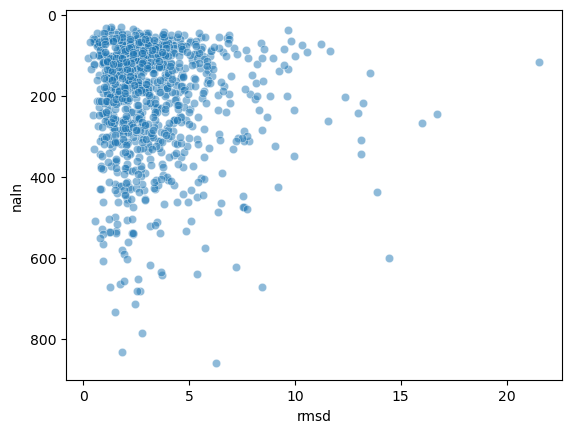

In [12]:
sns.scatterplot(data=df_fam, x='rmsd', y='naln', alpha=0.5)
plt.plot()

In [13]:
import ipywidgets as widgets

In [14]:
def inter_fam(fam):
    df = fetch_df(fam)

    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.gca().set_aspect('equal', 'box')
    plt.plot(np.linspace(0, 1), np.linspace(0, 1), color='black', alpha=0.5, zorder=0)
    sns.scatterplot(data=df_fam, x='seqid_ss', y='seqid_aa', alpha=0.5)
    sns.scatterplot(data=df, x='seqid_ss', y='seqid_aa')
    
    plt.subplot(1, 2, 2)
    plt.gca().set_aspect('equal', 'box')
    plt.plot(np.linspace(0, 1), np.linspace(0, 1), color='black', alpha=0.5, zorder=0)
    sns.scatterplot(data=df_fam, x='f1_fs', y='f1_dali', alpha=0.5)
    sns.scatterplot(data=df, x='f1_fs', y='f1_dali')
    plt.show()

In [16]:
df_cand = df_fam.query('rmsd > 2 and naln < 200 and fam_size>=5')
print(f'#cand={len(df_cand)}')

def plot_fam(x):
    print(df_cand.query(f'family == "{x}"').iloc[0, :])
    inter_fam(x)

widgets.interact(plot_fam, x=widgets.SelectionSlider(options=list(df_cand.family)));

#cand=59


interactive(children=(SelectionSlider(description='x', options=('toxin', 'hom', 'Sulfotransfer', 'DEATH', 'LIM…

# Figure

In [17]:
selected_fam = 'PH'
selected_query = '1dro'
selected_targets = '1mai 1b55a 1dyna 1qqga'.split()

rows = [df_all[(df_all.family == selected_fam) & (df_all.name1 == selected_query) & (df_all.name2 == target)].iloc[0, :] for target in selected_targets]
df_selected = pd.DataFrame(rows)
df_selected

,family,firstlast,name1,name2,f1_dali,sens_dali,prec_dali,f1_fs,sens_fs,prec_fs,seqid_ss,seqid_aa
8,PH,False,1dro,1mai,0.752688,0.707071,0.804598,0.608696,0.565657,0.658824,0.151261,0.058824
2,PH,False,1dro,1b55a,0.649746,0.640000,0.659794,0.333333,0.320000,0.347826,0.229508,0.098361
6,PH,False,1dro,1dyna,0.755102,0.732673,0.778947,0.694737,0.653465,0.741573,0.265487,0.123894
3,PH,False,1dro,1qqga,0.810811,0.797872,0.824176,0.847059,0.765957,0.947368,0.339806,0.184466


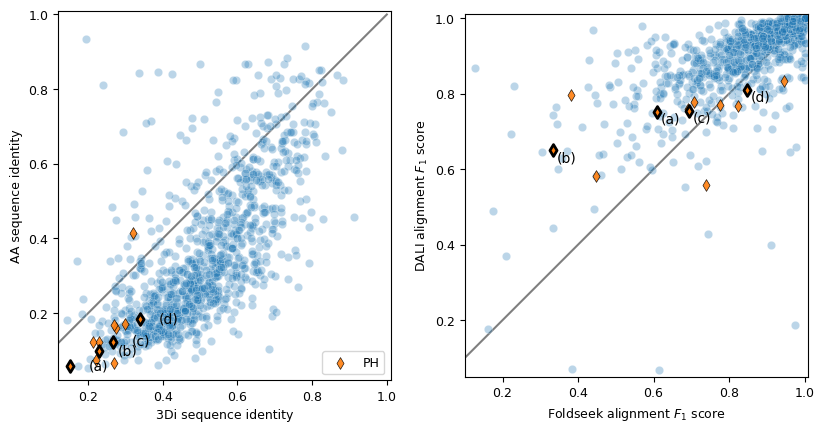

In [18]:
w_inch = 6.5
h_inch = 3.2

plt.rc('legend',fontsize=9)
plt.rc('xtick', labelsize=9)
plt.rc('ytick', labelsize=9)
plt.rc('axes', labelsize=9)
plt.rc('axes', titlesize=11)

scale = 1.5
plt.figure(figsize=(w_inch * scale, h_inch * scale))

fams = ['PH']
marker = 'd'

# Left side ----------------------------------------------------------------------------------------------------
ax = plt.subplot(1, 2, 2)
ax.set_aspect('equal', 'box')

plt.plot(np.linspace(0, 1), np.linspace(0, 1), color='black', alpha=0.5, zorder=0)
sns.scatterplot(data=df_all[df_all.firstlast], x='f1_fs', y='f1_dali', alpha=0.3)


for fam in fams:
    df_fam = df_all[df_all.family == fam]
    sns.scatterplot(data=df_fam, x='f1_fs', y='f1_dali', label=fam, alpha=0.9, edgecolor='black', marker=marker)
    
if selected_fam:
    sns.scatterplot(data=df_selected, x='f1_fs', y='f1_dali', color='tab:orange', zorder=5, edgecolor='black', linewidth=2, marker=marker)
    for letter, (_, row) in zip('abcd', df_selected.iterrows()):
        plt.annotate('(' + letter + ')', (row.f1_fs+0.01, row.f1_dali-0.03))

plt.legend().remove()

plt.xlabel('Foldseek alignment $F_1$ score')
plt.ylabel('DALI alignment $F_1$ score')
plt.xlim([0.10, 1.01])
plt.ylim([0.05, 1.01])

# Right side ----------------------------------------------------------------------------------------------------

ax = plt.subplot(1, 2, 1)
ax.set_aspect('equal', 'box')

plt.plot(np.linspace(0, 1), np.linspace(0, 1), color='black', alpha=0.5, zorder=0)

sns.scatterplot(data=df_all[df_all.firstlast], x='seqid_ss', y='seqid_aa', alpha=0.3)

for fam in fams:
    df_fam = df_all[df_all.family == fam]
    sns.scatterplot(data=df_fam, x='seqid_ss', y='seqid_aa', label=fam, alpha=0.9, edgecolor='black', marker=marker)    

if selected_fam:
    sns.scatterplot(data=df_selected, x='seqid_ss', y='seqid_aa', color='tab:orange', zorder=5, edgecolor='black', linewidth=2, marker=marker)
    for letter, (_, row) in zip('abcd', df_selected.iterrows()):
        plt.annotate('(' + letter + ')', (row.seqid_ss+0.05, row.seqid_aa-0.01))

plt.xlabel('3Di sequence identity')
plt.ylabel('AA sequence identity')
plt.xlim([0.12, 1.01])
plt.ylim([0.02, 1.01])
ax.get_legend()
plt.savefig('homstrad_divergent_series2.pdf', dpi=400)
plt.show()

# Alignments

In [22]:
mat_ss, alphabet_ss = homstrad_util.read_submat('../../foldseek/data/mat3di.out')

def ss_plus(a, b):
    return mat_ss[alphabet_ss.index(a), alphabet_ss.index(b)] > 0

In [35]:
def hmstrd_ss_seq(family, name1, name2):
    ref_aln = homstrad_util.parse_homstrad_ali(f'homstrad_db/{family}/{family}.ali')
    name2seqaln = {name: seqaln for name, seqaln in ref_aln}
    name2ss = {k.split('.')[0]: v for k, v in homstrad_util.read_fasta(f'out/hmstrd_pdbs/{family}/ss.fasta').items()}
    ss_aln1 = homstrad_util.exchange_seq(name2seqaln[name1], name2ss[name1])
    ss_aln2 = homstrad_util.exchange_seq(name2seqaln[name2], name2ss[name2])
    return ss_aln1, ss_aln2, 1, 1

def foldseek_ss_seq(family, name1, name2):
    df_fsres = pd.read_csv(f'out/hmstrd_pdbs/{family}/foldseek_tmp/result.tsv', delimiter='\t', names="query,target,qstart,tstart,qaln,taln,evalue,bits".split(','))
    cand = [row for i, row in df_fsres.iterrows() if row.query.startswith(name1) and row.target.startswith(name2)]
    assert len(cand) == 1, cand
    row = cand[0]
    name2ss = {k.split('.')[0]: v for k, v in homstrad_util.read_fasta(f'out/hmstrd_pdbs/{family}/ss.fasta').items()}
    ss_aln1 = homstrad_util.exchange_seq(row.qaln, name2ss[name1][row.qstart-1:], require_same_len=False)
    ss_aln2 = homstrad_util.exchange_seq(row.taln, name2ss[name2][row.tstart-1:], require_same_len=False)
    return ss_aln1, ss_aln2, row.qstart, row.tstart

def remove_unaligned_ends(aln1, aln2, start1, start2):    
    for _ in range(2):
        unaligned_offset_front =  max(len(aln1) - len(aln1.lstrip('-')), len(aln2) - len(aln2.lstrip('-')))
        unaligned_offset_back =  max(len(aln1) - len(aln1.rstrip('-')), len(aln2) - len(aln2.rstrip('-')))
        start1 += len(aln1[:unaligned_offset_front].replace('-', ''))
        start2 += len(aln2[:unaligned_offset_front].replace('-', ''))
        aln1 = aln1[unaligned_offset_front:]
        aln2 = aln2[unaligned_offset_front:]
        if unaligned_offset_back > 0:
            aln1 = aln1[:-unaligned_offset_back]
            aln2 = aln2[:-unaligned_offset_back]
        
    return aln1, aln2, start1, start2
    
def fix_hmstrd_alignment(aln1, aln2, start1, start2):
    """
    - remove unaligned head and tail
    - remove double gaps (originating from the msa)
    """
    aln1, aln2, start1, start2 = remove_unaligned_ends(aln1, aln2, start1, start2)
    
    new_aln1, new_aln2 = '', ''
    for a,b in zip(aln1, aln2):
        if a != '-' or b != '-':
            new_aln1 += a
            new_aln2 += b    
        
    return new_aln1, new_aln2, start1, start2

def format_tup(family, name1, name2, fn=None):
    s = ''
    
    s += f'{family} {name1} - {name2}\n'
    s += 'HOMSTRAD\n'
    ss_aln1, ss_aln2, start1, start2 = fix_hmstrd_alignment(*hmstrd_ss_seq(family, name1, name2))
    aln_fmt = homstrad_util.format_aln(name1, name2, ss_aln1, ss_aln2, start1, start2, line_len=80, include_name=True, draw_plus=ss_plus).rstrip('\n') + '\n'
    s += aln_fmt
    if fn:
        with open(f'out/aln_{fn}_hmstrd.txt', 'w') as file:
            file.write(aln_fmt)
    
    s += '\nFoldseek\n'    
    ss_aln1, ss_aln2, start1, start2 = foldseek_ss_seq(family, name1, name2)
    aln_fmt = homstrad_util.format_aln(name1, name2, ss_aln1, ss_aln2, start1, start2, line_len=80, include_name=True, draw_plus=ss_plus).rstrip('\n') + '\n'
    s += aln_fmt
    if fn:
        with open(f'out/aln_{fn}_fs.txt', 'w') as file:
            file.write(aln_fmt)
    
    print(s)

In [36]:
for k, target in enumerate(selected_targets):
    format_tup(selected_fam, selected_query, target, str(k+1))
    print('*' * 90)

PH 1dro - 1mai
HOMSTRAD
1dro      1 D------PDDDDDAAAWDQFWKQKFDDDDDAVPHPDHIDGATWDDAAA---KTFGARDCAVVVVDVQDHPVVTDMGGALQ
            |               |+++|++ +          +++++ +|+       |+|   |         |++ |  +++  +
1mai      1 DLVPDPLNVVQQV---WAFWWWFDAQ---------PRTHTKIWHQHP-VNFKIFIHDDDP-------DDDRVVRIDTLVF

1dro     72 W-AWDADC------DDDQSNL---KIWTGGPP-RIIIITRDDDNVVRVVSVVGRHCRNN
            + |+++++      +         ++||+|++   |++++++|+| ++   | + ++| 
1mai     61 FDAKAFAQPDPRCVHRVPVADRLFWMWTDGDDPDDITTIGHPDSVNSCSVRVVSVVSND

Foldseek
1dro     11 WDQFWKQKFDDDDDAVPHPDHIDGATWDDAA--AKTFGARDCAVVVVDVQDHPVVTDMGGALQW-AWDADCDD-------
            |+++|++      || |   ++++ +|+     +|+|   |      |  |+ ||  +++  ++ |++++++|       
1mai     14 WAFWWWF------DAQP---RTHTKIWHQHPVNFKIFIHDD------DPDDDRVVR-IDTLVFFDAKAFAQPDPRCVHRV

1dro     81 --DQSNLKIWTGG--PPRIIIITRDDDNVVRVVSVV
              + +  ++||+|  |+ |++|+ ++|+| ++   |
1mai     78 PVADRLFWMWTDGDDPDDITTIG-HPDSVNSCSVRV

******************************************

## RMSD

In [38]:
# HOMSTRAD
for target in selected_targets:
    val, naln = hmstrd_rmsd(selected_fam, selected_query, target)
    print(target, val.round(1), naln)

1mai 5.4 99
1b55a 5.6 100
1dyna 4.3 101
1qqga 3.4 94


In [40]:
# Foldseek
!mkdir -p out/showcases
!cp out/hmstrd_pdbs/{selected_fam}/{selected_query}.pdb out/showcases/
for target in selected_targets:
    !cp out/hmstrd_pdbs/{selected_fam}/{target}.pdb out/showcases/

In [61]:
%%bash --out out

FOLDSEEK=../../../git/foldseek/build/src/foldseek

$FOLDSEEK easy-search out/showcases/1dro.pdb out/showcases/ out/showcases/aln tmp \
    --exhaustive-search -e 100000 -a --format-mode 5

In [63]:
df_fsres = pd.read_csv(f'out/hmstrd_pdbs/{fam}/foldseek_tmp/result.tsv', delimiter='\t', names="query,target,qstart,tstart,qaln,taln,evalue,bits".split(','))
for target in selected_targets:
    row = df_fsres[(df_fsres['query'] == selected_query + '.pdb') & (df_fsres['target'] == target + '.pdb')].iloc[0, :]
    r, naln = homstrad_util.rmsd(f'out/showcases/{selected_query}.pdb', f'out/showcases/aln1dro.pdb_{target}.pdb.pdb', row.qaln, row.taln, row.qstart, row.tstart, glob=False)
    print(target, r.round(1), naln)

1mai 5.5 85
1b55a 6.7 92
1dyna 4.2 89
1qqga 3.2 76
